## Transfer Learning Tutorial:

This tutorial uses the hymenopetra dataset with ants and bees

These two major transfer learning scenarios looks as follows:

* __Finetuning the convnet:__
    Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

* __ConvNet as fixed feature extractor:__
Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode
%matplotlib inline

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


/Users/paulblankley/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
/Users/paulblankley/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


### Data loaded:

Now lets look at a few images.

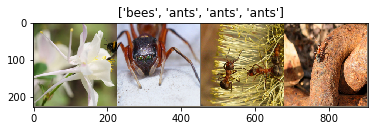

In [5]:
# Peek at some of the images 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training Function:

Now we are going to build a training function to train an arbitrary network for a number of epochs.

In [6]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    """ This function takes a model with a current state, saves that state as the current best state,
    then then trains the model with the optimizer and learning rate schedule given in the input.  
    In training, the model uses the given criterion input for the loss funcion, and the dataloaders 
    which is a dict with train and val keys and torchvision DataLoader objects.
    ----------
    Args: dataloaders: dict; with 'train' and 'val' keys and torchvision DataLoader objects.
          model; a nn.Module or nn.Sequential torch model.
          criterion; the loss function, specified from one of the nn.* loss options
          optimizer; the chosen optimizer for the coefficients (i.e SGD, Adam, etc) from torch.optim
          scheduler; the learning rate scheduler; an lr_scheduler object from torch.optim 
          num_epochs; int, the number of epochs to train, defaults to 25.
    ----------
    Returns; model; a nn.Module or nn.Sequential torch model, with the given structure, and 
                the best performing parameters (in terms of accuracy) during all epochs.
    """
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                
                # wrap the data with the Variable class
                inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

### Load the pre-trained model:

Here we load a pretrained model.

In [9]:
model_ft = models.resnet18(pretrained=True) # need internet to download the model
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/paulblankley/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:56<00:00, 822774.12it/s] 


#### Finetuning the CNN:

Here we fine tune the CNN, by incrementing *each possible parameter individually* in respect to the gradient.  This allows us to use the initial guess at the coefficients from the `resnet` model, and fine tune the coefficients with the 25 epochs we run here.

Epoch 0/24
----------
train Loss: 0.1523 Acc: 0.7049
val Loss: 0.0894 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.1646 Acc: 0.7500
val Loss: 0.0706 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.1319 Acc: 0.7623
val Loss: 0.0977 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.1433 Acc: 0.7623
val Loss: 0.1077 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.0864 Acc: 0.8811
val Loss: 0.0697 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.0934 Acc: 0.8402
val Loss: 0.1068 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.1684 Acc: 0.7623
val Loss: 0.0617 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.0779 Acc: 0.8730
val Loss: 0.0531 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.0931 Acc: 0.8566
val Loss: 0.0506 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.0794 Acc: 0.8607
val Loss: 0.0550 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.0801 Acc: 0.8320
val Loss: 0.0465 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0963 Acc: 0.8197
val Loss: 0.0476 Acc: 0.9346

Ep

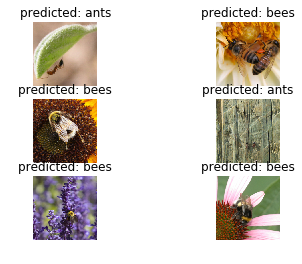

In [11]:
# Finetuning the CNN
model_ft = train_model(dataloaders, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
visualize_model(model_ft)

### Re-Load the pretrained model:

Here we reload the pretrained model again because we will use a different TL technique.

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters(): # freeze the update of the coefficients for the previous layers
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### Freeze the coefficients and train the final layer:

Here we freeze all the initial coefficients by setting the requires_grad=False tag, indicating that the gradient does not need to be calculated or model parameters updated. Next, we instanciate the final output layer of the network and fully train that layer. 

Epoch 0/24
----------
train Loss: 0.1593 Acc: 0.6557
val Loss: 0.0696 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.1094 Acc: 0.7951
val Loss: 0.0569 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.1323 Acc: 0.7377
val Loss: 0.0739 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.1816 Acc: 0.6680
val Loss: 0.1089 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.1307 Acc: 0.8074
val Loss: 0.0722 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.1092 Acc: 0.8279
val Loss: 0.0471 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.1039 Acc: 0.8238
val Loss: 0.0860 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.1240 Acc: 0.8074
val Loss: 0.0574 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.0829 Acc: 0.8607
val Loss: 0.0411 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.0752 Acc: 0.8402
val Loss: 0.0468 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.0911 Acc: 0.8566
val Loss: 0.0418 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0866 Acc: 0.8402
val Loss: 0.0406 Acc: 0.9477

Ep

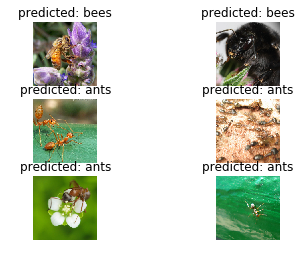

In [16]:
model_conv = train_model(dataloaders, model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
visualize_model(model_conv)
plt.ioff()
plt.show()